<b> Описание задачи</b>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import holidays

## Подготовка

Загрузим и проверим данные:

In [2]:
path='https://code.s3.yandex.net/datasets/'
file_name='taxi.csv'

df = pd.read_csv(path+file_name, index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

При загрузке добавил параметры parse_dates чтобы сразу преобразовать даты в datetime формат и index_col чтобы назначить столбец с датами индексирующим. Чтобы даты точно были отсортированы в хронологическом порядке использовал метод sort_index.

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Датасет представляет собой временной ряд с датой и временем заказов такси и количеством заказов. Интервал в datetime - 10 минут. Поскольку ТЗ предписывает прогнозировать спрос на такси на следующий час, изменим интервал при помощи ресемплинга на ежечасный

In [6]:
df = df.resample('1H').sum()

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Посмотрим на временной ряд за весь период с разбивкой по 1 дню.

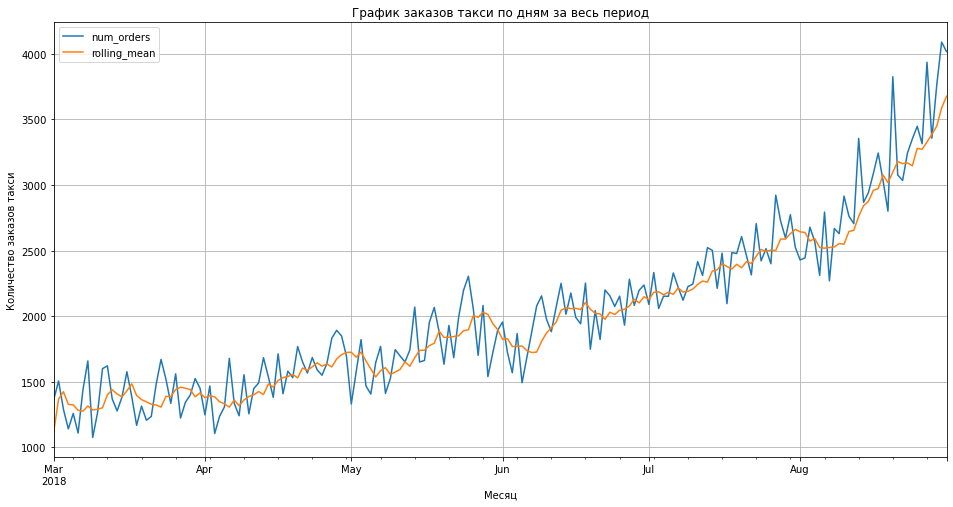

In [8]:
df['rolling_mean'] = df.rolling(150, min_periods=5).mean()
df.resample('1D').sum().plot(grid = True, figsize=(16, 8))
plt.ylabel('Количество заказов такси')
plt.xlabel('Месяц')
plt.title('График заказов такси по дням за весь период');
df = df.drop('rolling_mean', axis=1)

In [9]:
df.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [10]:
df.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

Данные представлены за период c 1 марта по 31 августа, то есть ровно за полгода. Наблюдается восходящий тренд: в марте скользящее среднее не превышает 1500 заказов в день, в середине периоде среднее находится около 2000, в конце - выше 3000. Вероятнее всего будет прослеживаться дневная сезонность. Построим графики по периоду, ограниченному двумя неделями:

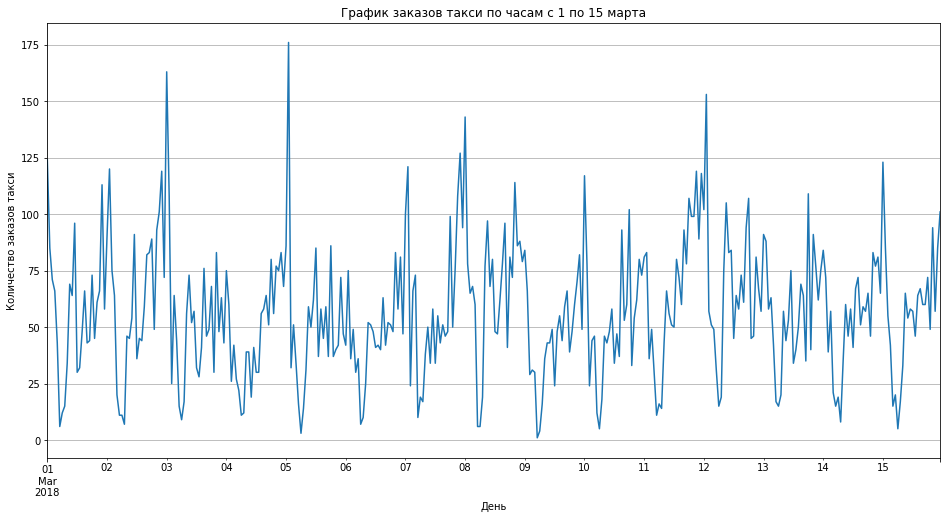

In [11]:
df['2018-03-01':'2018-03-15'].resample('1H').sum().plot(grid = True, figsize=(16, 8), legend=False)
plt.ylabel('Количество заказов такси')
plt.xlabel('День')
plt.title('График заказов такси по часам с 1 по 15 марта');

Дневная сезонность прослеживается. Также возможно будет прослеживаться недельная сезонность. В этом отрывке пиковые значения наблюдаются с пятницы на субботу, с воскресенья на понедельник и 8 марта. Чтобы подтвердить это или опровергнуть, рассмотрим другой временной промежуток без праздников с помощью столбчатой диаграммы.

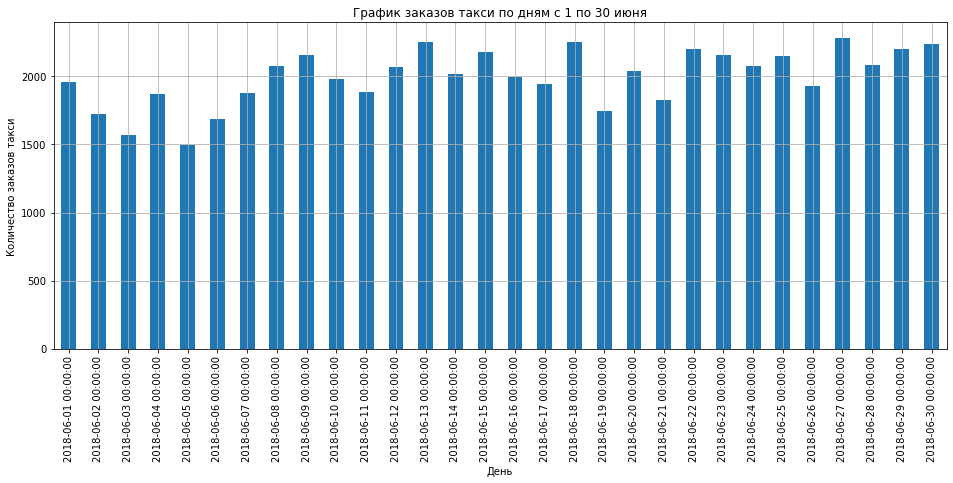

In [12]:
df['2018-06-01':'2018-06-30'].resample('1D').sum().plot(kind = 'bar', grid = True, figsize=(16, 6), legend=False)
plt.ylabel('Количество заказов такси')
plt.xlabel('День')
plt.title('График заказов такси по дням с 1 по 30 июня');

* При визуальном анализе очевидной зависимости количества вызовов такси в зависимости от дня недели не наблюдается

Воспользуемся функцией seasonal_decompose() чтобы выделить составляющие временного ряда

In [13]:
decomposed = seasonal_decompose(df) 

In [14]:
def decompose(decomposed):
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

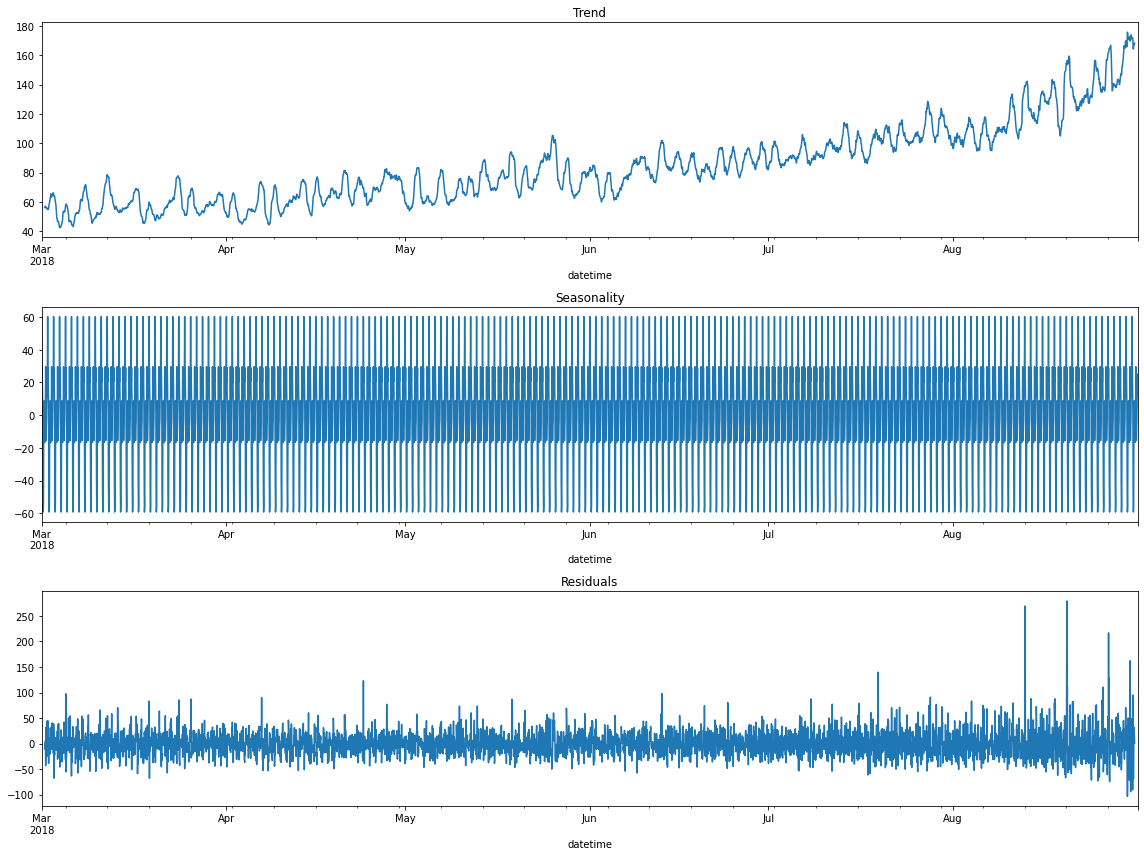

In [15]:
decompose(decomposed)

Наблюдаемый тренд подтверждается. Ежедневная сезонность, вероятнее всего, тоже подтверждается, но из-за длины ряда на этом графике она не очень хорошо отображается. Также в ряде довольно много шума, который возрастает в конце периода. Рассмотрим часть временного периода (июнь) при помощи функции

In [16]:
decomposed_june = seasonal_decompose(df['2018-06-01':'2018-06-30']) 

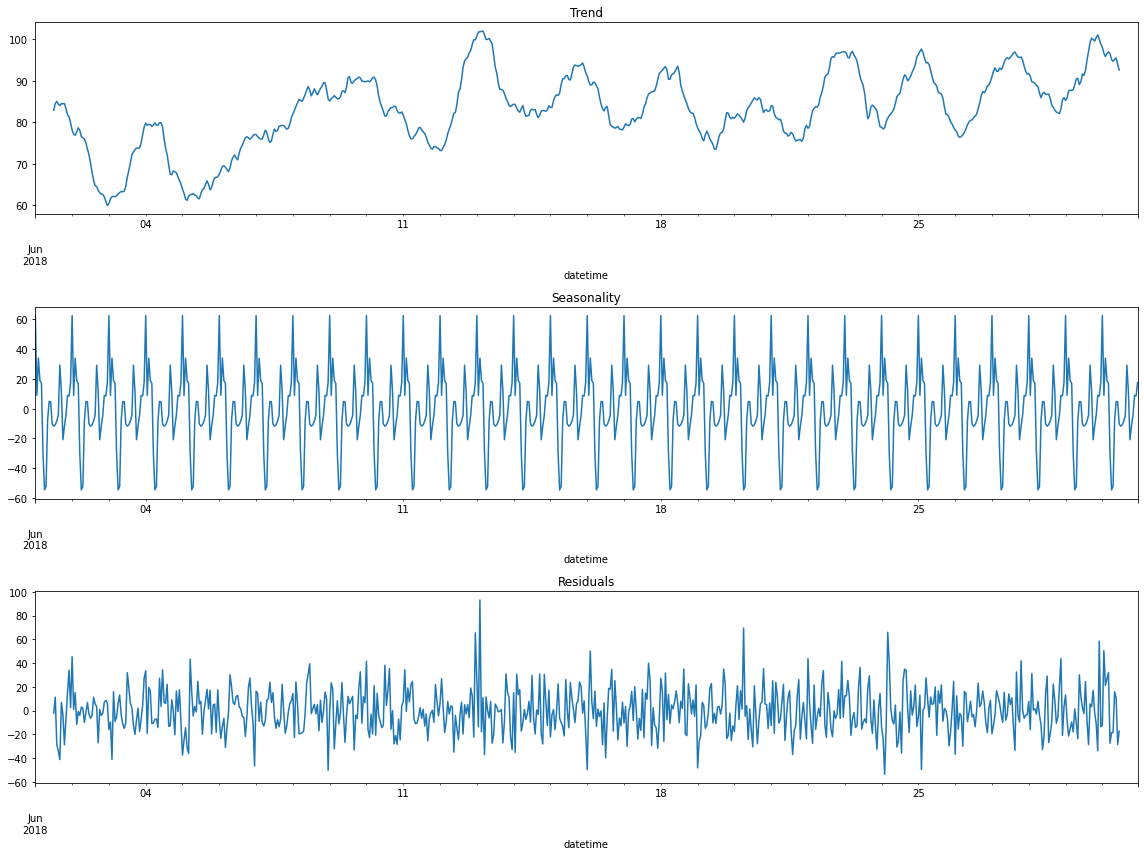

In [17]:
decompose(decomposed_june)

* Дневная сезонность теперь очень хорошо видна, функция правильно отделила шум

По итогам анализа опредили:
* Временной ряд охватывает период в 6 месяцев
* Ряд нестационарный
* Тренд восходящий
* Присутствует ярковыраженная дневная сезонность
* Очевидной зависимости количества вызовов такси от дня недели не наблюдается
* Присутствует шум, который возрастает в конце периода, что снизит качество прогноза на тестовой выборке при отсутствии дополнительных признаков, помогающих предсказать шум

## Обучение

In [18]:
random_state = 42

### Линейная регрессия

Создадим копии исходного сета чтобы проверить разные варианты обработки и/или использовать иные модели на исходном ряде

In [19]:
data = df.copy()
df1 = df.copy()

Создадим дополнительные признаки

Опытным путём проверил, что:
* Признак номер месяца никак не влияет на результат
* День в месяце никак не влияет на результат
* Скользящее среднее никак не влияет на результат
* День недели очень незначительно влияет на результат
* Параметры линейной регрессии почти не влияют на результат
* Дополнительные признаки - количество сдвигов невероятно сильно влияют на результат

Создадим признак дня недели. Несмотря на то, что визуальный анализ не помог выявить его значение, линейная регрессия всё таки обучается чуть лучше (сотые доли метрики RMSE) при его наличии:

In [20]:
df['dayofweek'] = df.index.dayofweek

Создадим алгоритм, который помогает понять, какое количество сдвигов нужно добавить в датасет чтобы получить максимальное RMSE. Алгоритм подбирает количество сдвигов на валидационной выборке, тестовая лишь технически отделяется чтобы в будущем повторить аналогичное разбиение вне функции:

In [21]:
def findlag(min_lag, max_lag):
    df2 = df.copy()
    best_model = None
    best_lag = 0
    best_predict = 0
    best_result = -np.inf
    for lag in tqdm(range(min_lag, max_lag + 1)):
        df2['lag_{}'.format(lag)] = df2['num_orders'].shift(lag)
        train_valid, test = train_test_split(df2, test_size=0.1, shuffle=False)
        train, valid = train_test_split(train_valid, test_size=0.1112, shuffle=False)
        train = train.dropna()
        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        features_valid = valid.drop('num_orders', axis=1)
        target_valid = valid['num_orders']
        model = LinearRegression(copy_X=False, fit_intercept=True, normalize=True)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)     
        result =  (mean_squared_error(predict, target_valid)**0.5)*-1
        if result > best_result:
            best_predict = predict
            best_model = model
            best_result = result
            best_lag = lag
    print("Достигнут лучший RMSE:", best_result*-1, "при сдвиге", best_lag)

In [22]:
findlag(1, 200)

100%|██████████| 200/200 [00:04<00:00, 40.52it/s]

Достигнут лучший RMSE: 28.01983494029604 при сдвиге 169


Достигнут лучший RMSE: 28.01983494029604 при сдвиге 169

На валидационной выборке подобрано оптимальное количество сдвигов - 169. Интересно, что 169 часов это почти ровно 7 суток. RMSE многообещающий, но на тесте будет хуже из-за большой волатильности целевого признака в августе.

Добавим найденное количество сгенерированных признаков в основной датасет:

In [23]:
for lag in range(1, 169 + 1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

Разделим выборки на обучающую, валидационную и тестовую с учетом особенностей работы с временными рядами и требования ТЗ:

In [24]:
train_valid, test = train_test_split(df, test_size=0.1, shuffle=False)
train, valid = train_test_split(train_valid, test_size=0.1112, shuffle=False)

In [25]:
def check_tvt(train, valid, test):
    return print('Минимальное значение обучающей выборки:', train.index.min()),\
           print('Максимальное значение обучающей выборки', train.index.max()),\
           print('----------------------'),\
           print('Минимальное значение валидационной выборки:', valid.index.min()),\
           print('Максимальное значение валидационной выборки', valid.index.max()),\
           print('----------------------'),\
           print('Минимальное значение тестовой выборки:', test.index.min()),\
           print('Максимальное значение тестовой выборки', test.index.max());

In [26]:
check_tvt(train, valid, test);

Минимальное значение обучающей выборки: 2018-03-01 00:00:00
Максимальное значение обучающей выборки 2018-07-26 03:00:00
----------------------
Минимальное значение валидационной выборки: 2018-07-26 04:00:00
Максимальное значение валидационной выборки 2018-08-13 13:00:00
----------------------
Минимальное значение тестовой выборки: 2018-08-13 14:00:00
Максимальное значение тестовой выборки 2018-08-31 23:00:00


Количество объектов в выборках должно быть следующее: ~80% обучающая, ~10% валидационная, ~10% тестовая (по ТЗ). Проверим:

In [27]:
print('В обучающей выборке объектов, %:', len(train) / len(df)*100)
print('В валидационной выборке объектов, %:', len(valid) / len(df)*100)
print('В тестовой выборке объектов, %:', len(test) / len(df)*100)

В обучающей выборке объектов, %: 79.98188405797102
В валидационной выборке объектов, %: 10.009057971014492
В тестовой выборке объектов, %: 10.009057971014492


Данные распределены с учетом временного фактора. В обучающей выборке будет период с 1 марта по 26 июля, в валидационной с 26 июля по 13 августа, в тестовой с 13 по 31 августа. Хронология соблюдена, данные не перемешались. К сожалению, именно в августе больше всего шумов и выбросов, что может ухудшить метрику на тесте. Однако, не уверен, что было бы честно брать в качестве тестового период например из середины ряда.

Обработаем данные и обучим модели:

In [28]:
train = train.dropna()
train_valid = train_valid.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

# эту же процедуру провожу с train+valid выборкой чтобы сделать предикт на тесте используя именно её
features_train_valid = train_valid.drop('num_orders', axis=1)
target_train_valid = train_valid['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# сначала обучаю и проверяю регрессию точно как внутри функции - на валидации. RMSE должен совпасть с подобранным функией
model_valid_lr = LinearRegression(copy_X=False, fit_intercept=True, n_jobs=None, normalize=True)
model_valid_lr.fit(features_train, target_train)

predict_valid = model_valid_lr.predict(features_valid)

# теперь обучаю регрессию на train+valid выборке и делаю предикт на тесте
model_test_lr = LinearRegression(copy_X=False, fit_intercept=True, n_jobs=None, normalize=True)
model_test_lr.fit(features_train_valid, target_train_valid)

predict_test = model_test_lr.predict(features_test)

Найдем RMSE линейной регрессии на валидации, он должен совпасть с тем, который показала функция (28.019834940296036):

In [29]:
mean_squared_error(predict_valid, target_valid)**0.5

28.01983494029604

Найдем <b>RMSE линейной регрессии</b> на тесте:

In [30]:
mean_squared_error(predict_test, target_test)**0.5

34.7301646370423

* При подобранном оптимальном количестве дополнительных признаков, сразу же получилось с запасом достичь нужного заказчику результа  RMSE (ниже 48 по ТЗ).

### Простейшие модели

Проверим элементарные константные модели. Возможно их будет достаточно для решения задачи.

Создадим модель, которая медианные значения обучающего ряда проставляет в качестве прогноза на тесте.

In [31]:
pred_median = np.ones(test.shape[0]) * train_valid['num_orders'].median()

Посчитаем <b>RMSE констанной медианной </b> модели на тесте:

In [32]:
mean_squared_error(test['num_orders'], pred_median)**0.5

86.41465855206327

RMSE первой простейшей модели = 86. По условиям задания значение метрики RMSE на тестовой выборке должно быть не больше 48.

Создадим простую модель, которая проставляет предыдущие значения ряда в качестве прогноза на тесте.

In [33]:
train_valid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3805 entries, 2018-03-08 01:00:00 to 2018-08-13 13:00:00
Freq: H
Columns: 171 entries, num_orders to lag_169
dtypes: float64(169), int64(2)
memory usage: 5.0 MB


In [34]:
pred_previous = test.shift()
pred_previous.iloc[0][0] = train_valid.iloc[-1][0]

Найдем <b>RMSE наивной</b> модели:

In [35]:
mean_squared_error(test['num_orders'], pred_previous.fillna(train_valid['num_orders'].median())['num_orders'])**0.5

58.863923913221576

Эта модель показывает намного лучше RMSE, но всё ещё не дотягивает до целевого. И конечно сильно проигрывает обученной линейной регрессии. А вообще очень неплохая модель для временных рядов.

### Дерево

Для обучения остальных моделей буду использовать тот же преобразованный датасет, на котором линейная регрессия показала хороший результат, т.е. с дополнительными признаками.

#### Обучение с кросс-валидацией

Для кросс-валидации на временных рядах нужен особый метод, реализации которого импортирована в блокнот:

In [36]:
tss = TimeSeriesSplit(n_splits=10)

Метод должен работать примерно так:

<a href="https://imgur.com/h4cWpmU"><img src="https://i.imgur.com/h4cWpmU.png" title="source: imgur.com" /></a>

Зададим параметры для обучения дерева:

In [37]:
params_tree = {
            'max_depth':range(6, 40),
            'max_features': ['log2', 'auto','sqrt', None],
            'min_samples_leaf': [1, 3, 5, 8, 10, 12],
            'min_samples_split': [2, 4, 6, 10, 14, 16, 20],
              }

Подберем параметры при помощи RandomizedSearchCV:

Подбрались следующие гиперпараметры:
<br> {'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 6}
<br> Лучший RMSE на кросс-валидации: 25.62569170983689

Обучим и проверим модель:

In [38]:
def model_tree_testing(depth, features, split, leaf):
    model_tree = DecisionTreeRegressor(max_depth=depth, max_features=features, min_samples_split=split, min_samples_leaf = leaf,
                                       random_state=random_state)
    model_tree.fit(features_train_valid, target_train_valid)
    predicted_tree = model_tree.predict(features_test)
    return mean_squared_error(target_test, predicted_tree)**0.5

In [39]:
model_tree_testing(6, 'auto', 10, 12)

42.78584472460267

Результат получился хуже, чем у настроенной линейной регрессии, хотя и проходит под требование ТЗ. Есть вероятность, что метод кросс валидации для временных рядов TimeSeriesSplit отработал некорректно.

#### Обучение дерева без использования кросс-валидации

<i> Из-за большой разницы между результатом на кросс-валидации и тестом всё-таки решил проверить обычную валидацию. Опасаюсь, что разница может быть вызвана некорректной кросс-валидацией, хотя я использую TimeSeriesSplit.

Напишем функцию для подбора гиперпараметров:

In [40]:
def tree(train, target):
    best_model = None
    best_predict = 0
    best_result = -1000
    best_depth = 0
    best_features = 0
    best_split = 0
    best_leaf = 0
    
    for depth in tqdm([4, 6, 8, 10, 14, 18]):
        for features in ['log2', 'auto','sqrt']:
            for split in [2, 4, 6, 8, 10, 14]:
                for leaf in [1, 3, 5, 8, 10, 12]:
                    model = DecisionTreeRegressor(max_depth=depth, max_features=features, random_state=random_state,
                                                 min_samples_split=split, min_samples_leaf=leaf)
                    model.fit(train, target)
                    predict = model.predict(features_valid)
                    result = (mean_squared_error(predict, target_valid)**0.5)*-1
                    if result > best_result:
                        best_predict = predict
                        best_model = model
                        best_result = result
                        best_depth = depth
                        best_features = features
                        best_split = split
                        best_leaf = leaf
    print("Достигнуто лучшее RMSE:", best_result*-1, "при параметрах:")
    print("max_depth:", best_depth)
    print("max_features:", best_features)
    print("min_samples_split:", best_split)
    print("min_samples_leaf:", best_leaf)

Достигнуто лучшее RMSE: 34.35259698972728 при параметрах:

max_depth: 6

max_features: auto

min_samples_split: 14

min_samples_leaf: 3

RMSE модели более реальный, чем на кросс-валидации. Проверим на тесте, передав гиперпараметры в функцию:

In [41]:
model_tree_testing(6, 'auto', 14, 3)

45.74029618677186

Несмотря на перебор всех значений в примерно том же диапазоне, результат перебора хуже, чем с использованием RandomSearchCV с кросс-валидацией и с использованием TimeSeriesSplit. <b> Отсюда могу сделать вывод, что TimeSeriesSplit вероятнее всего работает корректно и причина плохого результата (по сравнению с настроенной регрессией) либо в настройке самой модели, либо в предобработке данных, т.к. я использовал конфигурацию фичей такую же, как с линейной регрессией</b>. Если дело в самой модели, то разброс значений между кросс-валидацией и тестом можно объяснить только данными августа, где у нас самое большее среднее и, вероятно, стандартное отклонение, а модель плохо с таким справляется и нужно как-то ей в этом помочь. Если дело в предобработке, то возможно стоит сгенерировать другие фичи, которые регрессии не помогли, а дереву помогут? Проверим

In [42]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['rolling_mean'] = data['num_orders'].shift().rolling(150).mean()

In [43]:
def findlag_tree(min_lag, max_lag):
    data2 = data.copy()
    best_model = None
    best_lag = 0
    best_predict = 0
    best_result = -np.inf
    for lag in tqdm(range(min_lag, max_lag + 1)):
        data2['lag_{}'.format(lag)] = data2['num_orders'].shift(lag)
        train_valid, test = train_test_split(data2, test_size=0.1, shuffle=False)
        train, valid = train_test_split(train_valid, test_size=0.1112, shuffle=False)
        train = train.dropna()
        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        features_valid = valid.drop('num_orders', axis=1)
        target_valid = valid['num_orders']
        model = DecisionTreeRegressor(random_state=random_state)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)     
        result =  (mean_squared_error(predict, target_valid)**0.5)*-1
        if result > best_result:
            best_predict = predict
            best_model = model
            best_result = result
            best_lag = lag
    print("Достигнут лучший RMSE:", best_result*-1, "при сдвиге", best_lag)

In [44]:
findlag_tree(1, 200)

100%|██████████| 200/200 [00:45<00:00,  4.43it/s]

Достигнут лучший RMSE: 38.6749419032753 при сдвиге 133


Достигнут лучший RMSE: 38.6749419032753 при сдвиге 133

C гиперпараметрами дерева по умолчанию находит лучший сдвиг - 133. С подобранными на кросс-валидации гиперпараметрами - 167, это примерно столько же, сколько вышло при подборе сдвига для линейной регрессии (с таким же сдвигом крутил параметры для дерева). Попробую оставить сдвиг 133, с которым дерево по умолчанию показало лучший RMSE на валидации + покрутить параметры с таким сдвигом. Интуитивно я уже понимаю, что скорее всего это ни к чему не приведёт, но всё таки попробовать стоит, дополнительные фичи добавил же. Но сначала убедимся, что на тесте с параметрами по умолчанию результат будет намного хуже, чем на валидации

In [45]:
for lag in range(1, 133 + 1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [46]:
data_train_valid, data_test = train_test_split(data, test_size=0.1, shuffle=False)
data_train, data_valid = train_test_split(data_train_valid, test_size=0.1112, shuffle=False)
check_tvt(data_train, data_valid, data_test);

Минимальное значение обучающей выборки: 2018-03-01 00:00:00
Максимальное значение обучающей выборки 2018-07-26 03:00:00
----------------------
Минимальное значение валидационной выборки: 2018-07-26 04:00:00
Максимальное значение валидационной выборки 2018-08-13 13:00:00
----------------------
Минимальное значение тестовой выборки: 2018-08-13 14:00:00
Максимальное значение тестовой выборки 2018-08-31 23:00:00


Отделим целевой признак во всех выборках и уберем пустые значения которые образовались вследствие сдвига:

In [47]:
data_train = data_train.dropna()
data_train_valid = data_train_valid.dropna()

X_train = data_train.drop('num_orders', axis=1)
y_train = data_train['num_orders']

X_valid = data_valid.drop('num_orders', axis=1)
y_valid = data_valid['num_orders']

X_train_valid = data_train_valid.drop('num_orders', axis=1)
y_train_valid = data_train_valid['num_orders']

X_test = data_test.drop('num_orders', axis=1)
y_test = data_test['num_orders']

Поскольку добавлены новые признаки, которые не попадают в шкалу измерений среднего числа заказов, масштабируем признаки:

<i> Не будем ничего масштабировать потому что это почти никак не повлияло на работу деревьев

Протестируем работу дерева без подбора гиперпараметров в этом варианте предобработки:

In [48]:
def model_tree_data_testing(features_train, target_train, features_test, target_test):
    model = DecisionTreeRegressor(random_state=random_state)
    model.fit(features_train, target_train)

    predicted = model.predict(features_test)

    return mean_squared_error(predicted, target_test)**0.5

In [49]:
model_tree_data_testing(X_train_valid, y_train_valid, X_test, y_test)

62.59120042818099

RMSE дерева с 133 сдвигами без подбора гиперпараметров на тестовой выборке - 59.5, что намного выше результата на валидации. Проверим всё ли ок с кодом, передадим в функцию обучения валидационные данные (как внутри функции по подбору оптимального количества сдвигов):

In [50]:
model_tree_data_testing(X_train, y_train, X_valid, y_valid)

38.6749419032753

Результат точно такой же, значит ошибки нет. Без подбора параметров на одной лишь генерации фичей модель работает очень плохо, по качеству примерно на уровне наивной. Переберем гиперпараметры с использованием кросс-валидации:

Лучший RMSE на кросс-валидации: 28.086541623839985
<br>Гиперпараметры: {'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'auto', 'max_depth': 6}

In [51]:
model = DecisionTreeRegressor(max_depth=6,
                              max_features='auto',
                              min_samples_split=10,
                              min_samples_leaf = 12,
                              random_state=random_state)

model.fit(X_train_valid, y_train_valid)
predicted_data_tree = model.predict(X_test)
mean_squared_error(predicted_data_tree, y_test)**0.5

48.41012190401106

На тесте результат не утешительный. Сведем основные цифры по разным деревьям в таблицу:

<a href="https://imgur.com/Sw4yeSz"><img src="https://i.imgur.com/Sw4yeSz.png" title="source: imgur.com" /></a>

Выводы следующие:
* Данные которые использовал для обучения регрессии подошли лучше и для дерева (больше фичей со сдвигами, меньше других фичей)
* RMSE на тесте всегда сильно отличается от валидации. При этом проверил корректность работы метода TimeSeriesSplit - он работает корректно и эффективно  по сравнению с обычной валидацией, которую написал вручную
* Вероятнее всего дело в самой модели - деревья не очень хорошо подходят для решения данной задачи. Возможно не очень хорошо подходят для работы с временными рядами в принципе. Или требуют совсем другой предобработки данных
* Возможно дело в особенностях работы самого метода TimeSeriesSplit - способствует переобучению деревьев
* Именно по этой причине я не буду уделять много внимания лесу, а просто обучу и протестирую его по лучшему для дерева варианту

### Случайный лес

Создадим сетку для перебора параметров:

In [52]:
params_forest = {
            'n_estimators' : [100, 125, 150, 200, 300],
            'max_depth':[40, 50, 60, 70, 80, 90, 100],
            'max_features': ['log2', 'auto','sqrt'],
            'min_samples_leaf': [1, 3, 5, 8, 10, 12, 15],
            'min_samples_split': [2, 4, 6, 10, 14, 16, 20],
              }

Воспользуемся RandomizedSearchCV для их подбора 

Лучший RMSE на кросс-валидации: 22.281951720580064
<br>Гиперпараметры: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90}

In [53]:
%%time
model_forest = RandomForestRegressor(n_estimators=300,
                                     max_depth=90,
                                     max_features='auto',
                                     min_samples_split=10,
                                     min_samples_leaf = 1,
                                     random_state=random_state)

model_forest.fit(features_train_valid, target_train_valid)

predicted_forest = model_forest.predict(features_test)

Wall time: 59.9 s


Найдем <b>RMSE случайного леса</b> на тестовой выборке:

In [54]:
mean_squared_error(target_test, predicted_forest)**0.5

39.22297080906926

* RMSE леса ожидаемо лучше дерева, но хуже линейной регрессии (34.7)

### LightGBM

Первой и единственной моделью градиентного бустинга, которую я обучу в этом проекте, будет LightGBM из-за своей невероятной скорости работы.

#### LightGBM со сдвигами

Для использования модели я добавлю в первоначальный датасет дополнительные признаки: день недели, день месяца, номер месяца, час в сутках, а также 169 сдвигов, как в предыдущем успешном опыте. Также я масштабирую признаки.

In [55]:
df1.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [56]:
df1['month'] = data.index.month
df1['dayofweek'] = data.index.dayofweek
df1['day'] = data.index.day
df1['hour'] = data.index.hour

In [57]:
df1['month'] = df1['month'].astype('int8')
df1['dayofweek'] = df1['dayofweek'].astype('int8')
df1['day'] = df1['day'].astype('int8')
df1['hour'] = df1['hour'].astype('int8')

In [58]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
 1   month       4416 non-null   int8 
 2   dayofweek   4416 non-null   int8 
 3   day         4416 non-null   int8 
 4   hour        4416 non-null   int8 
dtypes: int64(1), int8(4)
memory usage: 86.2 KB


Сделаем копию датасета перед созданием сдвигов чтобы позднее проверить вариант без них

In [59]:
df3 = df1.copy()

In [60]:
for lag in range(1, 169 + 1):
    df1['lag_{}'.format(lag)] = df1['num_orders'].shift(lag)

In [61]:
lgbm_train_valid, lgbm_test = train_test_split(df1, test_size=0.1, shuffle=False)

In [62]:
def check_tt(train_valid, test):
    return print('Минимальное значение обучающей выборки:', train_valid.index.min()),\
           print('Максимальное значение обучающей выборки', train_valid.index.max()),\
           print('----------------------'),\
           print('Минимальное значение тестовой выборки:', test.index.min()),\
           print('Максимальное значение тестовой выборки', test.index.max())

In [63]:
check_tt(lgbm_train_valid, lgbm_test);

Минимальное значение обучающей выборки: 2018-03-01 00:00:00
Максимальное значение обучающей выборки 2018-08-13 13:00:00
----------------------
Минимальное значение тестовой выборки: 2018-08-13 14:00:00
Максимальное значение тестовой выборки 2018-08-31 23:00:00


In [64]:
lgbm_train_valid = lgbm_train_valid.dropna()

X_train_valid_lgbm = lgbm_train_valid.drop('num_orders', axis=1)
y_train_valid_lgbm = lgbm_train_valid['num_orders']

X_test_lgbm = lgbm_test.drop('num_orders', axis=1)
y_test_lgbm = lgbm_test['num_orders']

Масштабируем признаки

<i> Не будем масштабировать потому что это не повлияло на работу LightGBM

Зададим сетку для подбора гиперпараметров

In [65]:
params_lgb = {
    'num_leaves':[5, 7, 10],
    'learning_rate': [0.1, 0.3],
    'max_depth':range(5, 10),
    'n_estimators': [200, 250, 300, 350, 400],
}

Подберем гиперпараметры

Лучший RMSE на кросс-валидации: 22.246648436231222
<br>Гиперпараметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 7}

In [66]:
%%time
model_lgbm = lgb.LGBMRegressor(random_state=random_state,
                             learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=7, verbose=1)
model_lgbm.fit(X_train_valid_lgbm, y_train_valid_lgbm)
predicted_lgbm = model_lgbm.predict(X_test_lgbm)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31443
[LightGBM] [Info] Number of data points in the train set: 3805, number of used features: 173
[LightGBM] [Info] Start training from score 79.336137
Wall time: 285 ms


In [67]:
mean_squared_error(y_test_lgbm, predicted_lgbm)**0.5

37.140216389944456

<b>RMSE LightGBM на тесте 37.14.</b> Это лучше дерева и леса, но всё ещё хуже линейной регрессии.

#### LightGBM без сдвигов

Попробуем обучить LightGBM без создания сдвигов. Если результат будет хороший, будет очень круто т.к. это позволит делать прогноз не на 1 час вперед, а на любой час в некотором временном периоде.

In [68]:
df3.head()

,num_orders,month,dayofweek,day,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,3,1,0
2018-03-01 01:00:00,85,3,3,1,1
2018-03-01 02:00:00,71,3,3,1,2
2018-03-01 03:00:00,66,3,3,1,3
2018-03-01 04:00:00,43,3,3,1,4


Проделаем аналогичные действия с датасетом без сдвигов.

In [69]:
lgb_train_valid, lgb_test = train_test_split(df3, test_size=0.1, shuffle=False)

In [70]:
check_tt(lgb_train_valid, lgb_test);

Минимальное значение обучающей выборки: 2018-03-01 00:00:00
Максимальное значение обучающей выборки 2018-08-13 13:00:00
----------------------
Минимальное значение тестовой выборки: 2018-08-13 14:00:00
Максимальное значение тестовой выборки 2018-08-31 23:00:00


In [71]:
lgb_train_valid = lgb_train_valid.dropna()

X_train_valid_lgb = lgb_train_valid.drop('num_orders', axis=1)
y_train_valid_lgb = lgb_train_valid['num_orders']

X_test_lgb = lgb_test.drop('num_orders', axis=1)
y_test_lgb = lgb_test['num_orders']

In [72]:
params_lgb2 = {
    'num_leaves':[5, 7, 10, 15, 21, 28, 35],
    'learning_rate': [0.04, 0.1, 0.12, 0.25],
    'max_depth':range(5, 15),
    'n_estimators': [200, 250, 300, 350, 400, 450, 500],
}

RMSE на кросс-валидации как всегда зашкаливает, хоть и немного ниже, чем в варианте со сдвигами. Учитывая этот результат, ожидаю увидеть RMSE на тесте немного выше, чем в варианте со сдвигами - чуть выше 40.

In [73]:
%%time
model_lgb = lgb.LGBMRegressor(random_state=random_state,
                             learning_rate=0.1, max_depth=5, n_estimators=350, num_leaves=10, verbose=1)
model_lgb.fit(X_train_valid_lgb, y_train_valid_lgb)
predicted_lgb = model_lgb.predict(X_test_lgb)

mean_squared_error(y_test_lgb, predicted_lgb)**0.5

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 3974, number of used features: 4
[LightGBM] [Info] Start training from score 78.290639
Wall time: 59.8 ms


42.736067085013886

Удалось достичь хорошего RMSE не используя признаки со сдвигами. Это означает, что при помощи этой модели можно прогнозировать любой час в течение некоторого периода. Такой задачи не стоит по ТЗ, но я считаю правильным предложить эту модель заказчику вместе с авторегрессионной

Проверим качество модели на более коротком горизонте:

In [74]:
mean_squared_error(y_test_lgb.head(221), pd.Series(predicted_lgb).head(221))**0.5

35.54716529079701

In [75]:
mean_squared_error(y_test_lgb.head(110), pd.Series(predicted_lgb).head(110))**0.5

30.226544325580573

На горизонте 1/2 от тестовой выборки качество заметно выше, на 1/4 - ещё выше. Построим график чтобы понимать как это выглядит:

In [76]:
quality_horizont = []
for i in range(1, len(y_test_lgb)):
    result = mean_squared_error(y_test_lgb.head(i), pd.Series(predicted_lgb).head(i))**0.5
    quality_horizont.append(result)

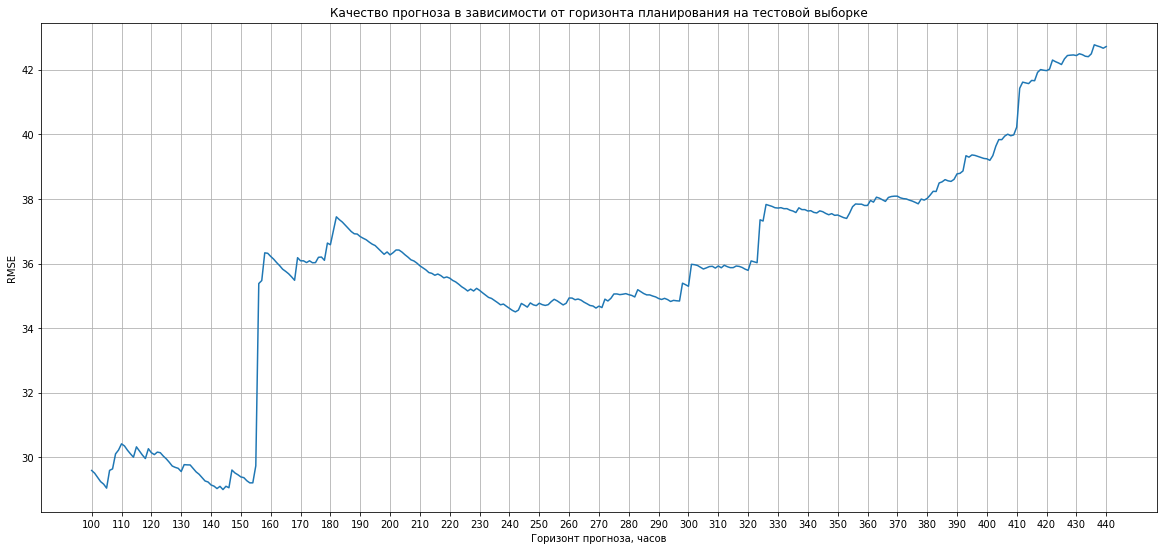

In [77]:
pd.Series(quality_horizont)[100:].plot(grid=True, figsize=(20, 9))
plt.title('Качество прогноза в зависимости от горизонта планирования на тестовой выборке')
plt.ylabel('RMSE')
plt.xlabel('Горизонт прогноза, часов')
plt.xticks(np.arange(100, len(quality_horizont), 10));

Если уменьшить горизонт прогноза, то качество модели ощутимо возрастает. При горизонте прогноза менее 158 часов, качество будет лучше, чем у линейной регрессии на ближайший час. То есть при прогнозировании не более, чем на неделю вперед, можно получить качество ~30 RMSE и ниже.

### ARIMA

Проверим как отработает классическая модель для прогнозирования временных рядов - ARIMA. На вход будем подавать только индексы с датой и количество заказов разбитые по часам. В теории модель сама должна организовать авторегрессию  и выдать предикт по заданным индексам (датам)

In [78]:
X_train_valid_arima, y_test_arima = train_test_split(df3, test_size=0.1, shuffle=False)
check_tt(X_train_valid_arima, y_test_arima);

Минимальное значение обучающей выборки: 2018-03-01 00:00:00
Максимальное значение обучающей выборки 2018-08-13 13:00:00
----------------------
Минимальное значение тестовой выборки: 2018-08-13 14:00:00
Максимальное значение тестовой выборки 2018-08-31 23:00:00


In [79]:
X_train_valid_arima['num_orders'].head()

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
Freq: H, Name: num_orders, dtype: int64

In [80]:
order = (5, 1, 0)
model_arima = ARIMA(X_train_valid_arima['num_orders'], order, freq='H')
model_arima = model_arima.fit()
arima_predicted = model_arima.predict("2018-08-13 14:00:00", "2018-08-31 23:00:00", typ='levels')

In [81]:
mean_squared_error(y_test_lgbm, arima_predicted)**0.5

60.85463876817992

In [82]:
model_arma = ARMA(X_train_valid_arima['num_orders'], (2, 1))
model_arma = model_arma.fit()
arma_predicted = model_arma.predict("2018-08-13 14:00:00", "2018-08-31 23:00:00")

In [83]:
mean_squared_error(y_test_lgbm, arma_predicted)**0.5

64.46003283317253

При помощи классических авторегрессионных моделей не получилось достичь результата с приемлимым уровнем качества

### Prophet

Обучим и протестируем модель от Facebook - prophet. Она создана для прогнозирования временных рядов, поэтому ожидаю получить хороший результат

Prophet требует немного иной предобработки. Создадим датасет с праздниками чтобы передать его в Prophet:

In [84]:
holidays_dict = holidays.RU(years=(2018))

In [85]:
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays

,ds,holiday
0,2018-01-01,Новый год
1,2018-01-02,Новый год
2,2018-01-03,Новый год
3,2018-01-04,Новый год
4,2018-01-05,Новый год
5,2018-01-06,Новый год
6,2018-01-07,Православное Рождество
7,2018-01-08,Новый год
8,2018-02-23,День защитника отечества
9,2018-03-08,День женщин


Подготовим данные для prophet, они должны быть загружены в модель в следующем виде:

In [86]:
data_prophet = pd.DataFrame(X_train_valid_arima).reset_index()
data_prophet = data_prophet.drop(['month', 'dayofweek', 'day', 'hour'], axis=1)
data_prophet.columns = ['ds', 'y']

In [87]:
data_prophet.tail()

,ds,y
3969,2018-08-13 09:00:00,137
3970,2018-08-13 10:00:00,156
3971,2018-08-13 11:00:00,144
3972,2018-08-13 12:00:00,92
3973,2018-08-13 13:00:00,119


Данные для prophet подготовлены. Тестовая выборка отсутствует изначально. При использовании этой библиотеки очень важен EDA, потому что некоторые гиперпараметры подкручиваются исходя из EDA, что намного проще и быстрее чем перебирать все возможные варианты циклами. Поэтому предлагаю ещё раз взглянуть на визуализацию данных, только на этот раз, чтобы всё было по-честному, тестовая выборка не будет включена в EDA.

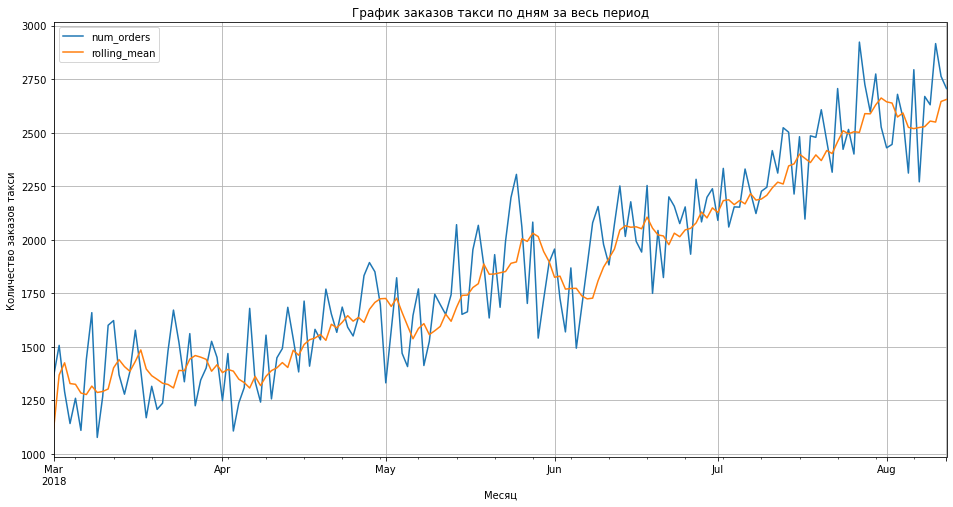

In [88]:
X_train_valid_arima['rolling_mean'] = X_train_valid_arima['num_orders'].rolling(150, min_periods=5).mean()
X_train_valid_arima[['num_orders', 'rolling_mean']].resample('1D').sum()[:-1].plot(grid = True, figsize=(16, 8))
plt.ylabel('Количество заказов такси')
plt.xlabel('Месяц')
plt.title('График заказов такси по дням за весь период');
X_train_valid_arima = X_train_valid_arima.drop('rolling_mean', axis=1)

* Тренд растущий, минимальные значения (около 1000 заказов в день) наблюдаются в начале марта и апреля, затем таких уровней не бывает. Максимальные значения на этом временном промежутке наблюдаются в конце июля и в августе. Вероятен дальнейший рост тренда, поэтому кап на предикте буду устанавливать выше, чем в обучающей выборке.

Построим графики, которые помогут определить floor и cap для обучения и для предикта. Эти параметры нужны prophet при использовании логистической функции роста.  Cap это параметр который замедляет восходящий тренд. Его устанавливают вблизи максимальных значений, там где дальнейший рост маловероятен например из-за насыщения рынка. Floor работает аналогично для минимальных значений.

Учитывая общий график, чтобы определить floor и cap для обучения, возьмем период, в котором наблюдаются минимальные значения и рассмотрим его почасовую разбивку (т.к. именно её будем прогнозировать):

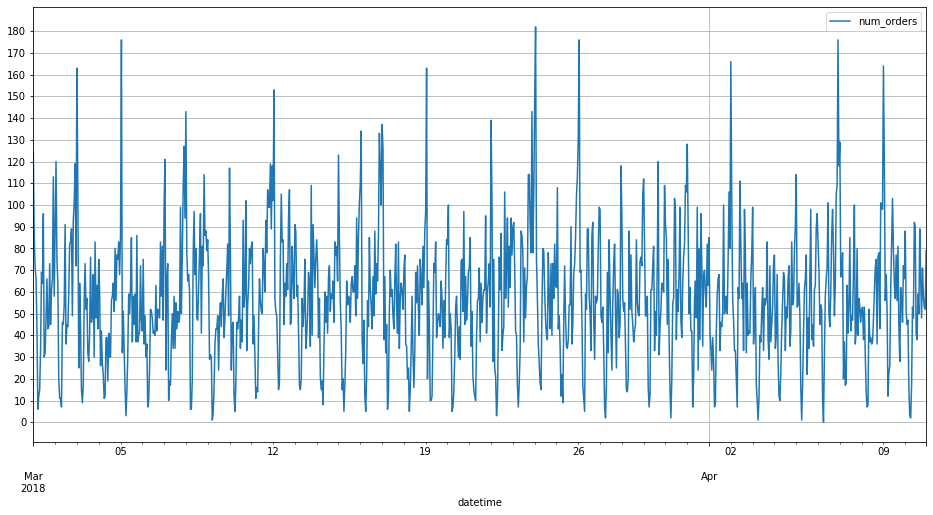

In [89]:
X_train_valid_arima['2018-03-01':'2018-04-10'][['num_orders']].plot(grid = True, figsize=(16, 8))
plt.yticks(np.arange(0, X_train_valid_arima['2018-03-01':'2018-04-10']['num_orders'].max(), 10));

* Floor для обучения целесообразно установить на уровне 10-15 заказов в час, cap на уровне 170-180 заказов в час.

Построим график чтобы определить floor для предикта. Для этого возьмем промежуток времени более близкий к прогнозируемому, где наблюдаются на общем графике максимальные значения:

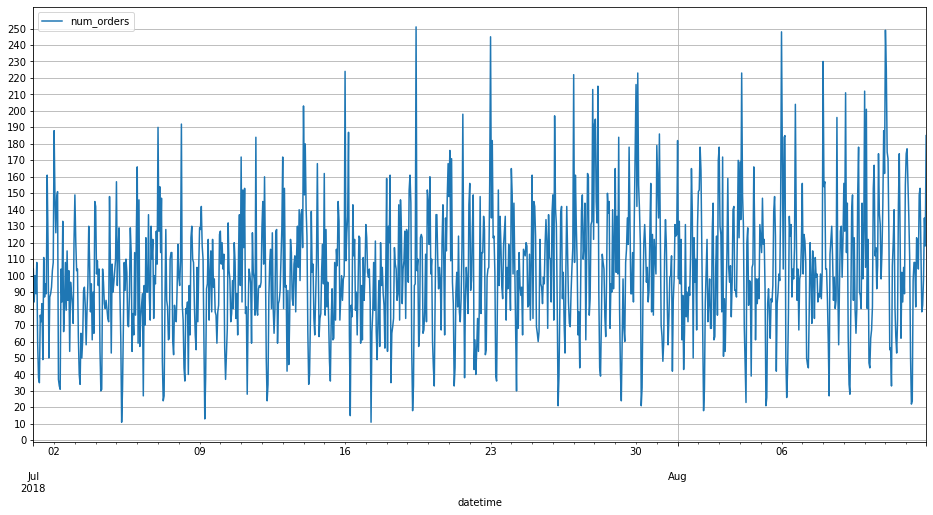

In [90]:
X_train_valid_arima['2018-07-01':'2018-08-12'][['num_orders']].plot(grid = True, figsize=(16, 8))
plt.yticks(np.arange(0, X_train_valid_arima['2018-07-01':'2018-08-12']['num_orders'].max(), 10));

* Floor для предикта целесообразно установить на уровне 15-25 заказов в час. Cap тоже должен быть выше, чем при обучении - на уровне 200-220 заказов в час.

Обучим модель, используя следующие параметры:
* Логистическую фунцию роста и мультипликативный режим сезонности используем т.к. ряд нестанционарный, в EDA было видно, что со временем растёт его среднее и стандартное отклонение
* Cap и floor определил визуально по графикам
* Установлена дневная сезонность т.к. она была ярковыражена по результатам EDA в начале проекта и подтверждена результатами работы других моделей
* Недельная сезонность была не очевидна по итогам EDA, но подтверждена результатами работы функции по подбору оптимального количества лагов для линейной регрессии
* Годовая сезонность будет отключена по очевидным причинам - у нас данные только за полгода

Создадим дополнительные признаки cap и floor:

In [91]:
data_prophet['cap'] = 175
data_prophet['floor'] = 10

In [92]:
fbp = Prophet(growth='logistic', 
              holidays=df_holidays,
              seasonality_mode = 'multiplicative',
              daily_seasonality=True, 
              weekly_seasonality=True, 
              yearly_seasonality=False)

fbp.fit(data_prophet)

Проверим RMSE модели на кросс-валидации:

In [93]:
cv_results = cross_validation(fbp, horizon='442 hours')
prophet_cv_rmse = (mean_squared_error(cv_results.y, cv_results.yhat)**0.5)
prophet_cv_rmse

INFO:fbprophet:Making 10 forecasts with cutoffs between 2018-05-04 06:00:00 and 2018-07-26 03:00:00


28.71055599316407

Сделаем прогноз на следующие 442 часа - размер выборки тестового датасета, на котором потом перепроверим качество привычным методом mean_squared_error:

In [94]:
future = fbp.make_future_dataframe(periods=442, freq='H')
future['cap'] = 210
future['floor'] = 20
forecast = fbp.predict(future)

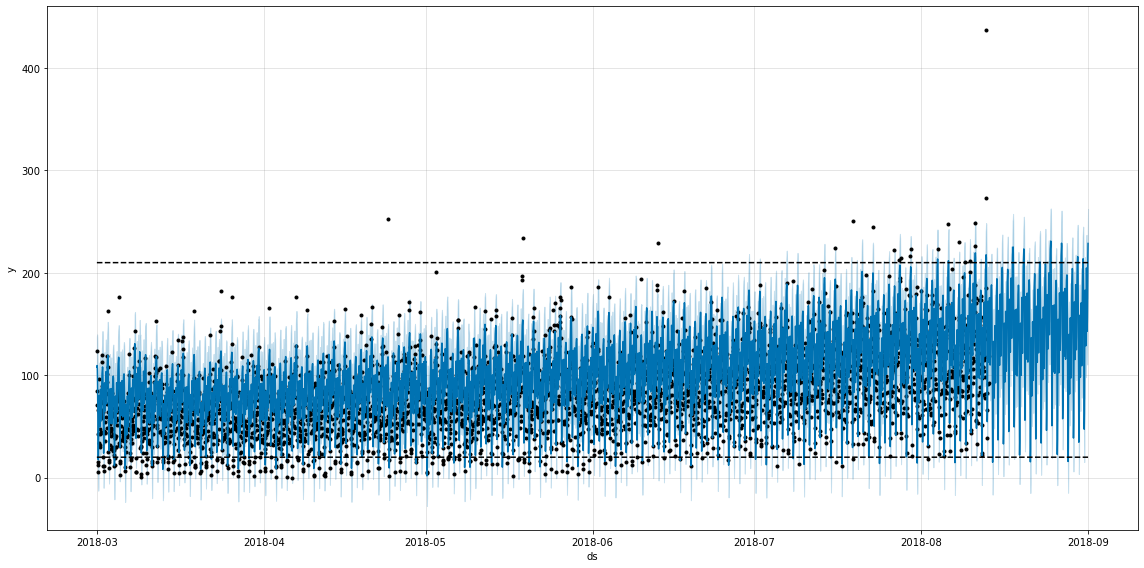

In [95]:
fig = fbp.plot(forecast, figsize=(16, 8))

RMSE Prophet на тесте:

In [96]:
mean_squared_error(y_test_lgbm, forecast['yhat'].tail(len(y_test_lgbm)))**0.5

40.85474041531627

Получился хороший RMSE, который также как и "LightGBM без сдвигов" может с таким качеством спрогнозировать весь период заранее.

In [97]:
mean_squared_error(y_test_lgbm.head(221), forecast.query('ds > "2018-08-13 13:00:00"')['yhat'].head(221))**0.5

40.03149580738984

При этом, если взять более короткий горизонт прогноза (половина от тестового), то его качество практически не меняется, в то время как "LightGBM без сдвигов" улучшает качество. 

<br>Итого по тестированию Prophet:
<br> Очень понравилась библиотека, неплохо работает "из коробки". У неё ещё есть много других возможностей, которые не были задействованы. Например, отмечу, что не использовал перебор параметров вообще, лишь немного подкрутил некоторые на основе EDA (без подкрутки, совсем уж "из коробки" RMSE на тесте - 48). В данном проекте буду рекомендовать prophet заказчику в качестве альтернативной модели, так как он также позволяет делать прогноз на некоторый промежуток времени вперед + имеет достаточное для заказчика качество + быстро обучается и настраивается + интерпретируемый + есть потенциал улучшения метрики при настройке гиперпараметров по сетке.

# Сравниение и выводы

Сведем результаты в таблицу и нарисуем графики прогноз/факт для лучших моделей:

<a href="https://imgur.com/N0CPoSQ"><img src="https://i.imgur.com/N0CPoSQ.png" title="source: imgur.com" /></a>

Модели с "+ shifts" работают с указанной метрикой RMSE только при прогнозе на 1 час вперед. В принципе, это подходит под ТЗ, где "нужно спрогнозировать количество заказов такси на следующий час", но всё-таки рекомендую использовать как основную модель <b>Prophet</b>. Также предлагаю 2 альтернативных варианта на выбор заказчика: обученный <b>LightGBM без использования сдвигов</b> и  <b>Линейная регрессия</b> под которую была написана функция для поиска оптимального количество сдвигов. RMSE всех моделей подходит под требования. Особенности обученных моделей:

<br> <b>Линейная регрессия со сдвигами (авторегрессия)</b>
* Быстро обучается
* Интерпретируемая
* Лучшая RMSE с учетом условий задачи
* Работает с указанной в таблице метрикой качества при условии прогнозирования спроса только на 1 час вперед
* При попытке прогнозировать спрос более, чем на 1 час, качество прогноза будет существенно ухудшаться

<br> <b>LightGBM без сдвигов</b>
* Быстро обучается
* Не интерпретируемый
* Может давать прогноз на любой час на прогнозном горизоне более 2х недель с указанным качеством
* RMSE на всей тестовой выборке хуже, чем у других рекомендуемых моделей
* При снижении прогнозного горизонта улучшается качество, так, при прогнозном горизонте менее 1 недели RMSE улучшается до 30 и меньше, что превосходит качество линейной регрессии, однако гарантировать такое качество на всем прогнозном горизонте нельзя

<br> <b>Prophet</b>
* Легко настраивается
* В принципе быстро обучается
* Интерпретируемый
* Возможно подстроить под бизнес задачу исходя из экспертного понимания проблемы прогнозирования
* Средний RMSE среди рекомендуемых
* Даёт стабильный прогноз на весь прогнозный горизонт
* Есть потенциал улучшить, донастроив параметры. Также можно улучшить, собрав больше данных для выстраивания годовой сезонности


Построим графики прогноз/факт на прогнозный период (по тестовой выборке) по каждой рекомендуемой модели:

In [98]:
# Свод данных прогноз/факт в таблицу для Prophet:

prophet_predict_values = pd.DataFrame(forecast['yhat'].tail(len(y_test_lgbm))).reset_index(drop=True).round().astype('int')
true_values = pd.DataFrame(y_test_lgbm).reset_index().drop('datetime', axis=1)
prophet_table = prophet_predict_values.join(true_values)
prophet_table = prophet_table.rename(columns={'yhat':'forecast', 'num_orders':'true_value'})

# Аналогичный свод для LightGBM:

lgbm_predict_values = pd.DataFrame(predicted_lgb).round().astype('int')
lgbm_table = lgbm_predict_values.join(true_values).rename(columns={0:'forecast', 'num_orders':'true_value'})

# Аналогичный свод для Линейной регрессии:

lr_predict_values = pd.DataFrame(predict_test).round().astype('int')
lr_table = lr_predict_values.join(true_values).rename(columns={0:'forecast', 'num_orders':'true_value'})

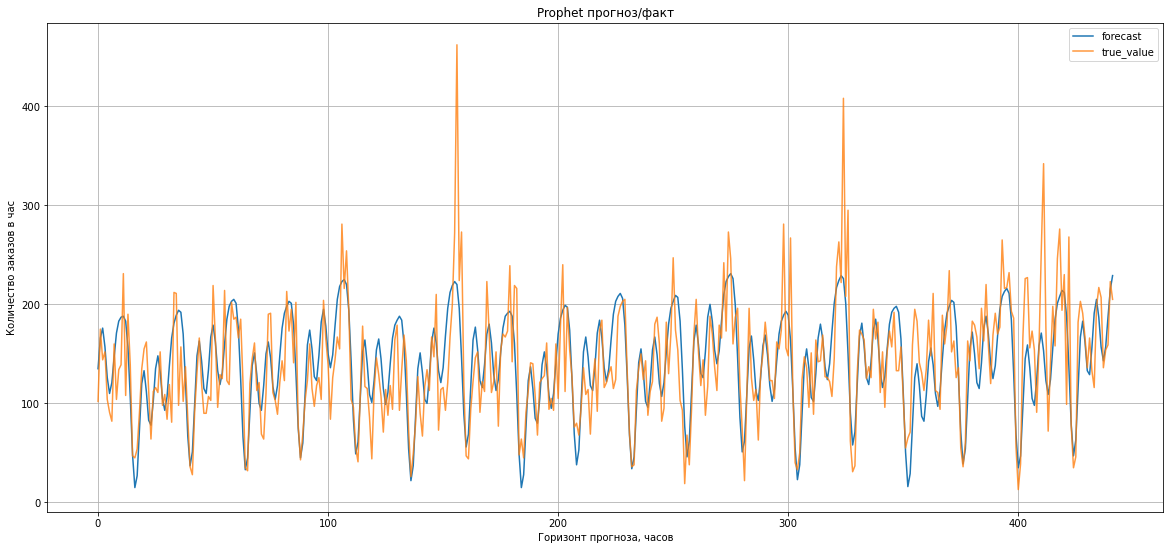

In [99]:
prophet_table['forecast'].plot(grid=True, figsize=(20, 9))
prophet_table['true_value'].plot(grid=True, figsize=(20, 9), alpha=0.8)
plt.legend()
plt.title('Prophet прогноз/факт')
plt.ylabel('Количество заказов в час')
plt.xlabel('Горизонт прогноза, часов');

* Видно, что модель в целом повторяет колебания внутри дня, но плохо отрисовывает резкие скачки значений. На декомпозиции именно эти скачки уходят в остатки. Располагая лишь имеющимися данными, их практически невозможно спрогнозировать. Но если получить дополнительные данные которые влияют на спрос на такси, например данные о погоде в исследуемом регионе, то можно намного лучше предсказывать и остатки.

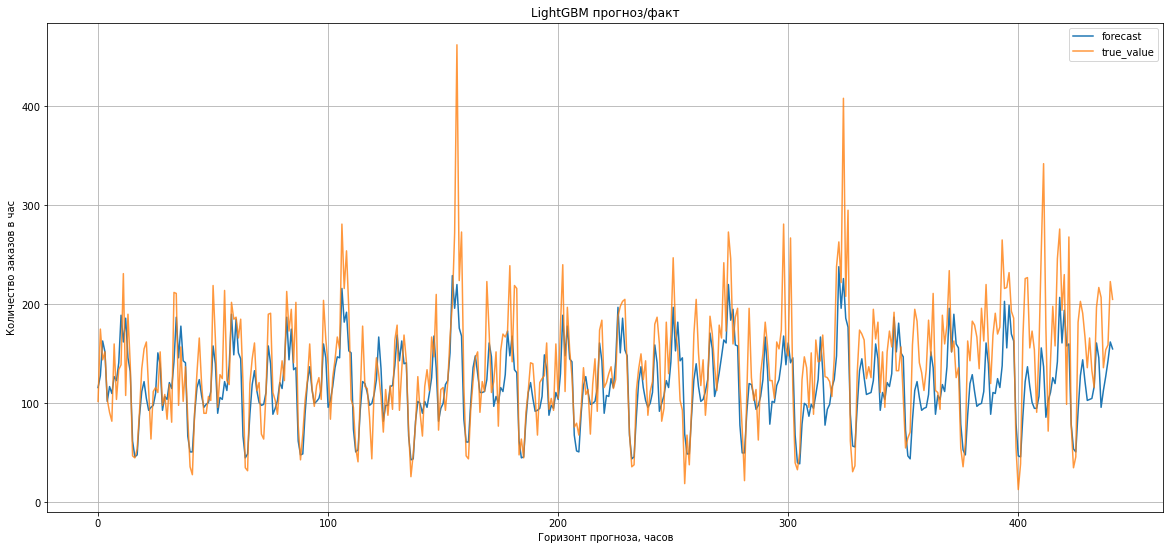

In [100]:
lgbm_table['forecast'].plot(grid=True, figsize=(20, 9))
lgbm_table['true_value'].plot(grid=True, figsize=(20, 9), alpha=0.8)
plt.legend()
plt.title('LightGBM прогноз/факт')
plt.ylabel('Количество заказов в час')
plt.xlabel('Горизонт прогноза, часов');

* С LightGBM ситуация похожа: модель плохо предсказывает резкие изменения значений внутри дня, однако здесь линия прогноза не такая гладкая, что связано с иным принципом работы модели. Имея дополнительные данные для прогнозирования остатков, хотелось бы в первую очередь переобучить именно LightGBM чтобы их учесть. Однако в Prophet тоже можно передавать дополнительные факторы в виде регрессоров.

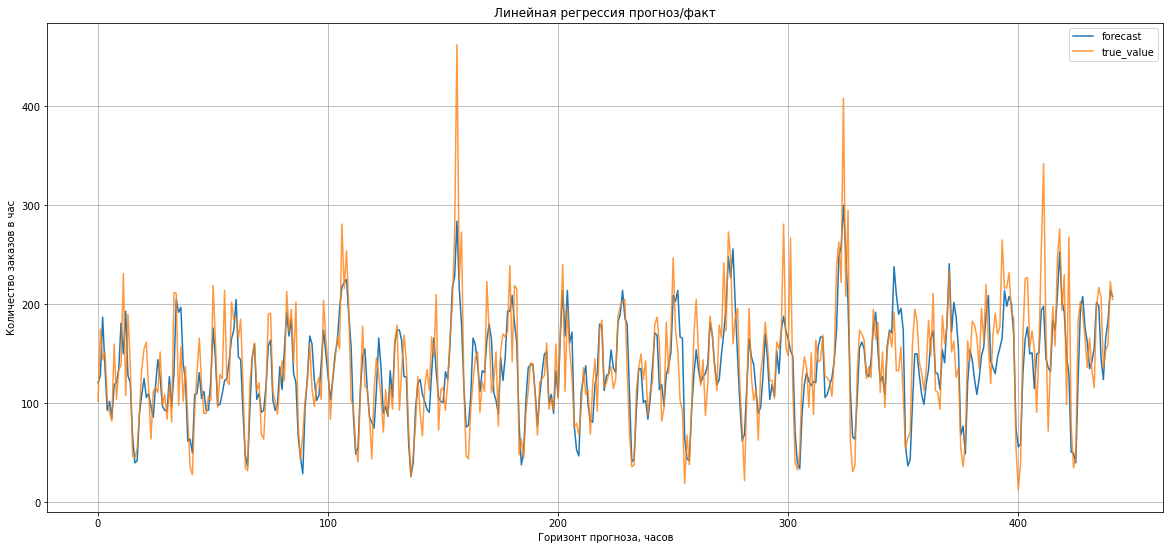

In [101]:
lr_table['forecast'].plot(grid=True, figsize=(20, 9))
lr_table['true_value'].plot(grid=True, figsize=(20, 9), alpha=0.8)
plt.legend()
plt.title('Линейная регрессия прогноз/факт')
plt.ylabel('Количество заказов в час')
plt.xlabel('Горизонт прогноза, часов');

* На графике видно, что прогноз линейной регрессии в большей степени повторяет факт, что подтверждает метрика. Однако существенная разница уже была отмечена - данная модель даёт прогноз лишь на 1 час вперед, в то время как две предыдущие сразу на весь прогнозный горизонт.

## Итог
В проекте было проверено множество моделей с разными вариантами предобработки данных. В результате заказчику предложено 3 лучших обученных модели на выбор. Для повышения точности прогноза и решения различных дополнительных задач могу рекомендовать комбинировать разные модели:
* При прогнозировании спроса на час вперед использовать авторегрессию: и по метрике, и по графику видно, что она с этим неплохо справляется
* При необходимости построить прогноз спроса на день вперед, неделю, или даже месяц, с учетом всех праздников - Prophet.
* При наличии дополнительных данных, которые помогут лучше спрогнозировать остатки - дообучить LightGBM (не займет много времени) и использовать его.